In [1]:
import pandas as pd
import altair as alt
from altair import datum

## Read in library web site page views data


In [2]:
pageviews = pd.read_csv('pageviews_2012_small.csv')
pageviews.head()

,timestamp,visitors,city,region,country,longitude,latitude,lcc_description
0,2012-01-01 16:00:00,1,Montreal,Quebec,Canada,-73.5542,45.5089,Military Science
1,2012-01-01 13:00:00,1,Durham,North Carolina,United States,-78.8986,35.9940,History Of The Americas
2,2012-01-01 10:00:00,1,Edinburgh,Scotland,United Kingdom,-3.1875,55.9502,Social Sciences
3,2012-01-01 18:00:00,1,Plymouth,England,United Kingdom,-4.1427,50.3704,NaN
4,2012-01-01 09:00:00,1,Edinburgh,Scotland,United Kingdom,-3.1875,55.9502,Social Sciences


In [3]:
len(pageviews)

10278

In [4]:
pageviews.dtypes

timestamp           object
visitors             int64
city                object
region              object
country             object
longitude          float64
latitude           float64
lcc_description     object
dtype: object

## Change ISO_time to a true date and time data type

In [5]:
pageviews['timestamp'] = pd.to_datetime(pageviews.timestamp)
pageviews.dtypes

timestamp          datetime64[ns]
visitors                    int64
city                       object
region                     object
country                    object
longitude                 float64
latitude                  float64
lcc_description            object
dtype: object

## MaxRowsError

Can take off limit for number of rows, but that's not a great idea because the notebook will have a Vega-Lite JSON specification (text) embedded for every output pane, which also includes the data, so you end up with huge notebooks!

Instead, we can specify that the outputs should just refer to a JSON file on your local drive and load in the data from there for each plot.

See the Altair tutorial notebook `03-Binning-and-aggregation` for more details.

In [6]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Simple summary charts

### Bars of visitors per country

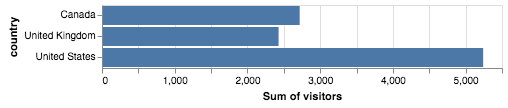

In [15]:
alt.Chart(pageviews).mark_bar().encode(
    x = 'sum(visitors)',
    y = 'country'
)

### Library of Congress Categories by country

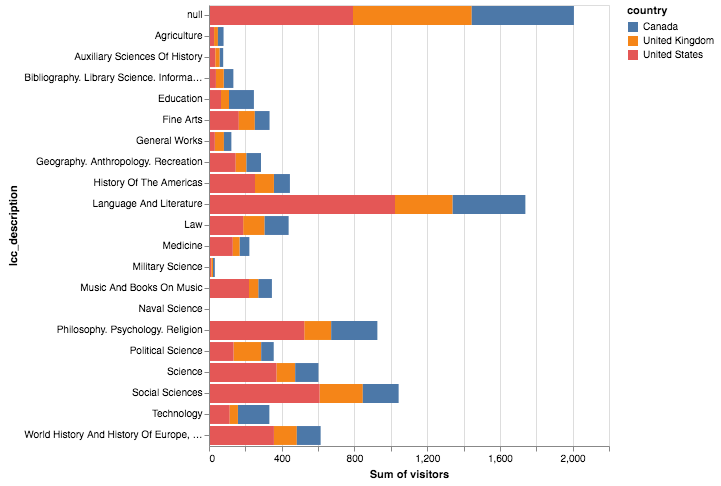

In [39]:
alt.Chart(pageviews).mark_bar().encode(
    x = 'sum(visitors)',
    y = 'lcc_description',
    color = 'country'
)

### Sort LCC category by number of visitors

Also include lines along numeric axis and log scale

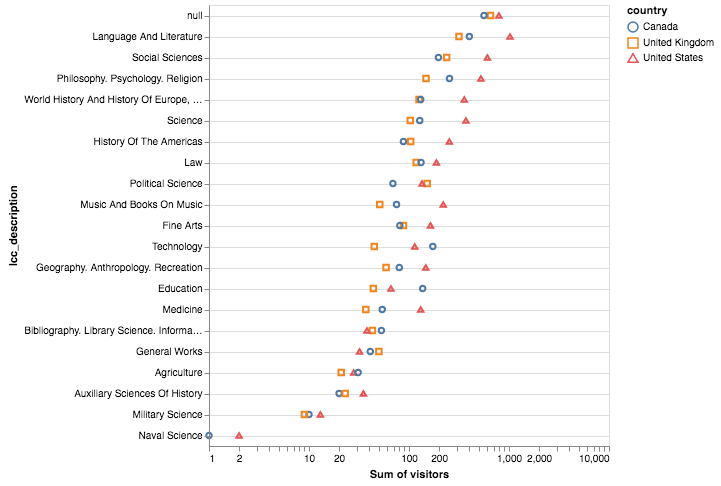

In [44]:
alt.Chart(pageviews).mark_point().encode(
    x = alt.X('sum(visitors)', scale=alt.Scale(type='log')),
    y = alt.Y('lcc_description',
            sort=alt.EncodingSortField(
                field="visitors",
                op="sum",
                order="descending")
    ),
    color = 'country',
    shape = 'country'
).configure_axisY(grid=True).configure_axisX(grid=False)

## TimeUnit transform: Visitors continuous time line

#### A sum of visitors per day shows some weekly and seasonal detail

[timeunit valid entries](https://altair-viz.github.io/user_guide/transform.html#timeunit-transform) are listed within a type of data transform called a **TimeUnit Transform**

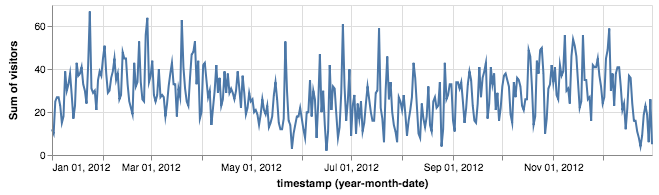

In [49]:
alt.Chart(pageviews).mark_line().encode(
    x = 'yearmonthdate(timestamp):T',
    y = 'sum(visitors):Q'
).properties(
    width=600,
    height=150
)

## transform_filter()

#### You can see the school holidays clearly in the Durham pageviews

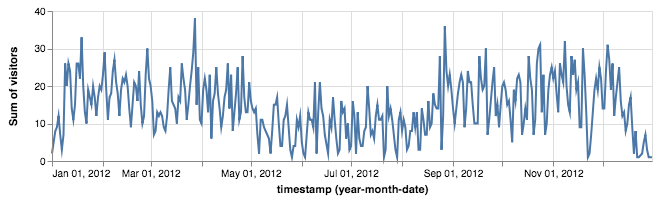

In [8]:
alt.Chart(pageviews).mark_line().encode(
    x = 'yearmonthdate(timestamp):T',
    y = 'sum(visitors):Q',
    tooltip = 'yearmonthdate(timestamp):T'
).transform_filter(
    datum.city == 'Durham'
).properties(
    width=600,
    height=150
)

## TimeUnit transform: Visitors by hour of day

[timeunit valid entries](https://altair-viz.github.io/user_guide/transform.html#timeunit-transform)

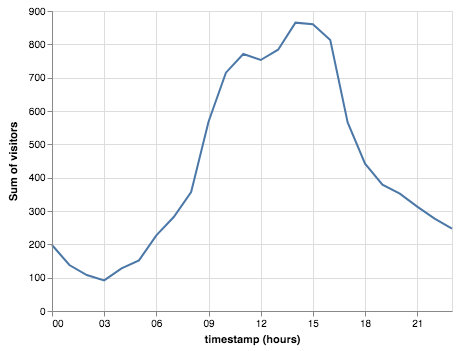

In [9]:
alt.Chart(pageviews).mark_line().encode(
    x= 'hours(timestamp):T',
    y = 'sum(visitors):Q'
)

### Canada, UK time shift

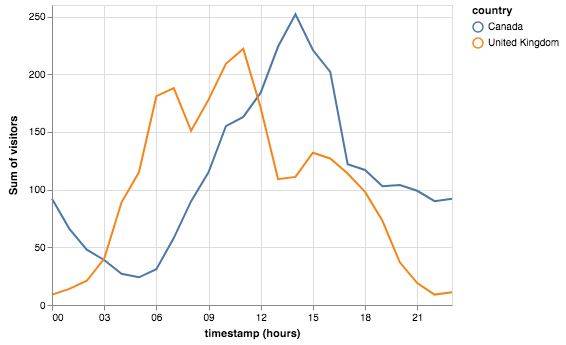

In [50]:
alt.Chart(pageviews).mark_line().encode(
    x = 'hours(timestamp):T',
    y = 'sum(visitors):Q',
    color = 'country'
).transform_filter(
    (datum.country == 'Canada') | (datum.country == 'United Kingdom')
)

## Weekday vs hour of day heatmap

*Notice here that we change from a Time data type to Ordinal to get discreet marks*

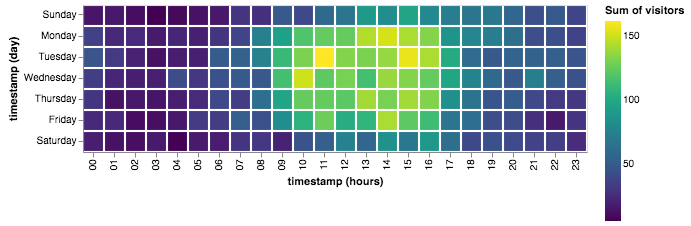

In [10]:
alt.Chart(pageviews).mark_rect().encode(
    x= 'hours(timestamp):O',
    y= 'day(timestamp):O',
    color='sum(visitors)'
)

# Maps

Mapping funcitonality isn't as advanced in Vega-Lite, and for now doesn't allow zooming and interaction beyond tooltips. You can still do some world and US filled maps and symbol maps, though.

## Visitors per country symbol map (version 1)

We'll use mean latitude and longitude from the data for the locations of the symbols for now and see how that works out

*Note again that with groupby you need to do all of your aggregation in the transform_aggregate() section!*

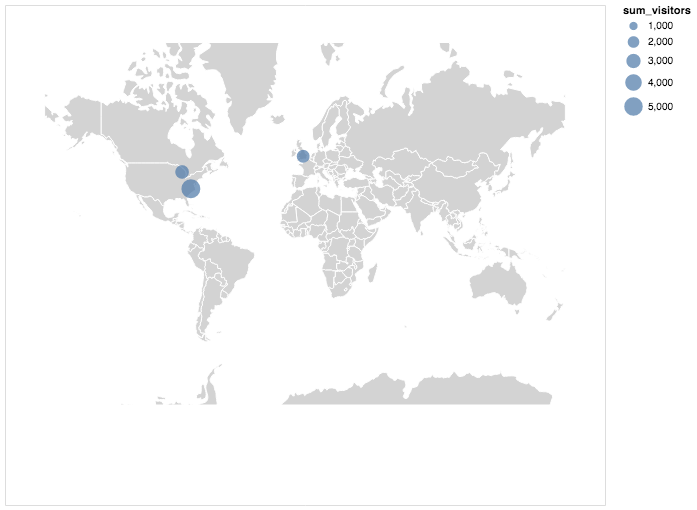

In [56]:
proj_type = 'mercator'
width = 600
height = 500
clip_extent = [[0,0.075*height],[width,0.8*height]]

background = alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project(
    type=proj_type,
    clipExtent=clip_extent
).properties(
    width=width,
    height=height
)

points = alt.Chart(pageviews).mark_circle().encode(
    longitude = 'mean_lon:Q',
    latitude = 'mean_lat:Q',
    size = 'sum_visitors:Q',
    tooltip = 'country'
).transform_aggregate(
    sum_visitors='sum(visitors)',
    mean_lat = 'mean(latitude)',
    mean_lon = 'mean(longitude)',
    groupby=['country']
).project(
    type=proj_type,
    clipExtent=clip_extent
).properties(
    width=width,
    height=height
)

background + points

## Looking up average Lat/Lon for countries

We'll load in country shapefiles from `vega_datasets` and read in a CSV file with the average lat/lon values per country.

In [52]:
from vega_datasets import data

In [54]:
countries = alt.topo_feature(data.world_110m.url, feature='countries')

latlon = pd.read_csv('average-latitude-longitude-countries.csv')
latlon.head()

,ISO 3166 Country Code,Country,Latitude,Longitude
0,AD,Andorra,42.50,1.50
1,AE,United Arab Emirates,24.00,54.00
2,AF,Afghanistan,33.00,65.00
3,AG,Antigua and Barbuda,17.05,-61.80
4,AI,Anguilla,18.25,-63.17


## Visitors per country symbol map (version 2)

### Doing data join within Altair using transform_lookup()

For some data sources (e.g. data available at a URL, or data that is streaming), it is desirable to have a means of joining data without having to download it for pre-processing in Pandas.

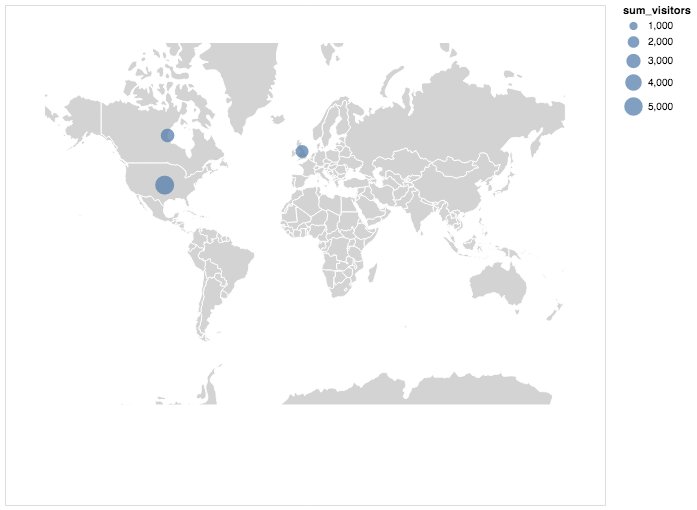

In [55]:
proj_type = 'mercator'
width = 600
height = 500
clip_extent = [[0,0.075*height],[width,0.8*height]]

background = alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project(
    type=proj_type,
    clipExtent=clip_extent
).properties(
    width=width,
    height=height
)

points = alt.Chart(pageviews).mark_circle().encode(
    longitude = 'Longitude:Q',
    latitude = 'Latitude:Q',
    size = 'sum_visitors:Q',
    tooltip = 'country'
).transform_aggregate(
    sum_visitors='sum(visitors)',
    groupby=['country']
).transform_lookup(
    lookup = "country",
    from_ = alt.LookupData(data=latlon, key='Country', fields=['Latitude','Longitude'])
).project(
    type=proj_type,
    clipExtent=clip_extent
).properties(
    width=width,
    height=height
)

background + points